In [1]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint # type: ignore #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model # type: ignore #tải mô hình
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore

#các lớp để xây dựng mô hình
from keras.models import Sequential # type: ignore #đầu vào
from keras.layers import LSTM # type: ignore #học phụ thuộc
from keras.layers import Dropout # type: ignore #tránh học tủ
from keras.layers import Dense # type: ignore #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score  # Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error  # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error, f1_score  # Đo % sai số tuyệt đối trung bình

from pymongo import MongoClient

In [21]:

# Kết nối đến MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['metadata']  
collection = db['MWG']  

# Chuyển dữ liệu thành DataFrame
df = pd.DataFrame(list(collection.find({}, {"_id": 0})))
df


,Ngay,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
0,2014-07-22,8.82,109.0,568890,61431000000,0,0,104.0,109.0,104.0,0.0,0.00
1,2014-07-23,8.82,109.0,23330,2550000000,0,0,110.0,110.0,108.0,0.0,0.00
2,2014-08-06,8.65,107.0,20800,2185000000,0,0,104.0,107.0,104.0,0.0,0.00
3,2014-08-13,10.03,124.0,147010,17690000000,0,0,119.0,125.0,117.0,0.0,0.00
4,2014-08-27,11.08,137.0,11450,1570440000,20000,2800000000,138.0,140.0,135.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2606,2024-12-17,60.30,60.3,3676200,222299000000,465600,28141480000,61.0,61.0,60.2,-0.7,-1.15
2607,2024-12-13,61.00,61.0,5596800,337974000000,237000,14314400000,59.8,61.3,59.6,0.0,0.00
2608,2024-12-18,60.20,60.2,4076200,244954000000,846000,51200640000,60.2,60.5,59.9,-0.1,-0.17
2609,2024-12-19,59.80,59.8,7103100,423511000000,483000,29311460000,59.8,59.9,59.4,-0.4,-0.66


In [22]:
# Kiểm tra dữ liệu
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2611 entries, 0 to 2610
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ngay               2611 non-null   object 
 1   GiaDieuChinh       2611 non-null   float64
 2   GiaDongCua         2611 non-null   float64
 3   KhoiLuongKhopLenh  2611 non-null   int64  
 4   GiaTriKhopLenh     2611 non-null   int64  
 5   KLThoaThuan        2611 non-null   int64  
 6   GtThoaThuan        2611 non-null   int64  
 7   GiaMoCua           2611 non-null   float64
 8   GiaCaoNhat         2611 non-null   float64
 9   GiaThapNhat        2611 non-null   float64
 10  ThayDoi_GiaTri     2611 non-null   float64
 11  ThayDoi_PhanTram   2611 non-null   float64
dtypes: float64(7), int64(4), object(1)
memory usage: 244.9+ KB


,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
count,2611.000000,2611.000000,2.611000e+03,2.611000e+03,2.611000e+03,2.611000e+03,2611.000000,2611.000000,2611.000000,2611.000000,2611.000000
mean,42.498399,98.926216,1.985096e+06,1.356950e+11,3.326291e+05,2.652231e+10,98.848851,100.123190,97.620050,0.070126,0.079219
std,18.779299,36.035290,3.285104e+06,1.778879e+11,9.038609e+05,8.070266e+10,35.964811,36.414385,35.587265,2.082046,1.976749
min,6.590000,35.100000,8.600000e+02,1.010000e+08,0.000000e+00,0.000000e+00,35.250000,37.400000,33.600000,-53.900000,-32.770000
25%,29.155000,69.650000,2.280800e+05,2.556450e+10,0.000000e+00,0.000000e+00,69.700000,70.200000,68.500000,-0.500000,-0.550000
50%,42.260000,102.100000,6.847000e+05,7.179900e+10,0.000000e+00,0.000000e+00,102.000000,103.400000,101.000000,0.000000,0.000000
75%,57.800000,127.550000,1.826860e+06,1.661550e+11,2.200780e+05,1.949504e+10,127.500000,129.000000,126.000000,0.500000,0.650000
max,87.030000,183.400000,2.961670e+07,1.653604e+12,1.227500e+07,1.525310e+12,183.500000,184.000000,180.300000,13.500000,19.850000


In [23]:
# Xử lý thời gian và sắp xếp dữ liệu
df['Ngay'] = pd.to_datetime(df['Ngay'], format='%Y-%m-%d')
df = df.sort_values(by='Ngay')

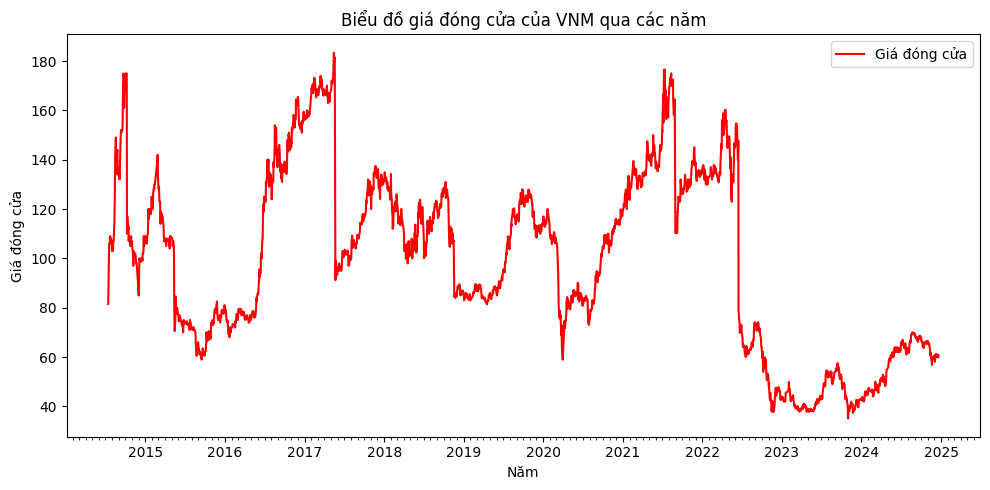

In [24]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Lấy thông tin năm từ cột "Ngày"
df['Nam'] = df['Ngay'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Ngay'], df['GiaDongCua'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của VNM qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()

In [25]:
# Chuyển đổi sang chỉ số thời gian
df1 = pd.DataFrame(df, columns=['Ngay', 'GiaDongCua'])
df1.index = df1['Ngay']
df1.drop('Ngay', axis=1, inplace=True)

In [26]:
df1

,GiaDongCua
Ngay,
2014-07-14,81.5
2014-07-15,87.0
2014-07-16,93.0
2014-07-17,99.5
2014-07-18,106.0
...,...
2024-12-16,61.0
2024-12-17,60.3
2024-12-18,60.2


In [27]:
# Chia tập dữ liệu
data = df1.values
train_data = data[:int(len(df) * 0.8)]
test_data = data[int(len(df) * 0.8):]

In [28]:
data

array([[81.5],
       [87. ],
       [93. ],
       ...,
       [60.2],
       [59.8],
       [60.6]])

In [29]:
# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(data)

In [30]:
# Tạo cửa sổ thời gian cho tập train
x_train, y_train = [], []
for i in range(50, len(train_data)):
    x_train.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_train.append(sc_train[i, 0])  # Giá trị tiếp theo
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [31]:
# Tạo cửa sổ thời gian cho tập test
x_test, y_test = [], []
for i in range(50, len(test_data)):
    x_test.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_test.append(sc_train[i, 0])  # Giá trị tiếp theo
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

C:\Users\TRUONG\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100

Epoch 1: loss improved from inf to 0.31136, saving model to save_models/MWG_model.keras
32/32 - 10s - 322ms/step - loss: 0.3114 - val_loss: 0.1840
Epoch 2/100

Epoch 2: loss improved from 0.31136 to 0.19519, saving model to save_models/MWG_model.keras
32/32 - 3s - 98ms/step - loss: 0.1952 - val_loss: 0.1482
Epoch 3/100

Epoch 3: loss improved from 0.19519 to 0.16333, saving model to save_models/MWG_model.keras
32/32 - 3s - 108ms/step - loss: 0.1633 - val_loss: 0.1232
Epoch 4/100

Epoch 4: loss improved from 0.16333 to 0.14082, saving model to save_models/MWG_model.keras
32/32 - 4s - 115ms/step - loss: 0.1408 - val_loss: 0.1050
Epoch 5/100

Epoch 5: loss improved from 0.14082 to 0.12406, saving model to save_models/MWG_model.keras
32/32 - 4s - 113ms/step - loss: 0.1241 - val_loss: 0.0973
Epoch 6/100

Epoch 6: loss improved from 0.12406 to 0.11392, saving model to save_models/MWG_model.keras
32/32 - 4s - 134ms/step - loss: 0.1139 - val_loss: 0.0871
Epoch 7/100

Epoch 7: loss

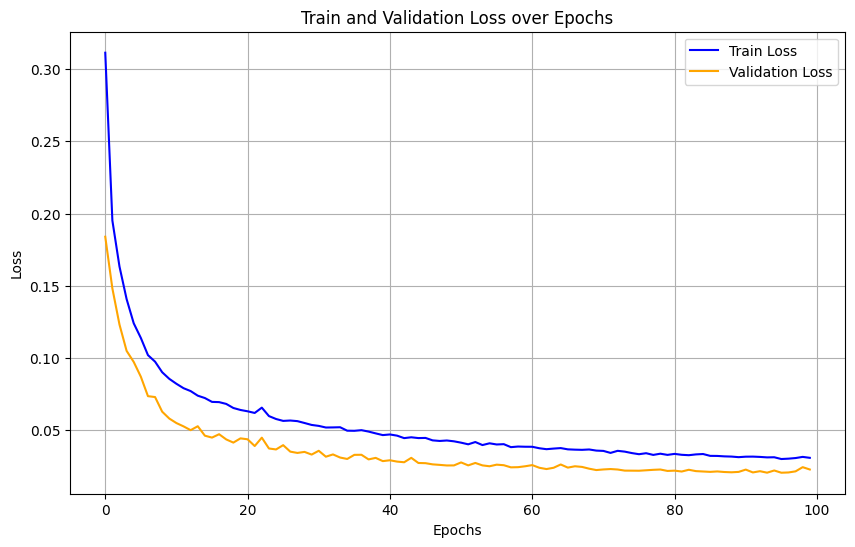

In [13]:
def build_model(input_shape):
    model = Sequential()
    # LSTM đầu tiên
    model.add(LSTM(units=128, input_shape=input_shape, return_sequences=True, kernel_regularizer=l2(0.001)))
    # LSTM thứ hai (giảm số neuron)
    model.add(LSTM(units=64, kernel_regularizer=l2(0.001)))
    # Dropout
    model.add(Dropout(0.4))
    # Lớp Dense đầu ra
    model.add(Dense(1))
    # Compile mô hình
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.0005))
    return model

# Xây dựng và huấn luyện
input_shape = (x_train.shape[1], x_train.shape[2])
model = build_model(input_shape)

callbacks = [
    ModelCheckpoint("save_models/MWG_model.keras", monitor='loss', verbose=2, save_best_only=True, mode='auto'),
    EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=2)
]

# Huấn luyện mô hình
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),  # Thêm tập validation
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=callbacks
)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')  # Thêm val_loss
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Hàm xây dựng mô hình
def build_model():
    model = Sequential()
    model.add(LSTM(units=128, input_shape=(x_train.shape[1], 1), return_sequences=True))
    model.add(LSTM(units=64))
    model.add(Dropout(0.4))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

In [19]:
# Huấn luyện mô hình
model = build_model()
save_model_path = f"save_models/{collection}_model.keras"
best_model = ModelCheckpoint(save_model_path, monitor='loss', verbose=2, save_best_only=True, mode='auto')
model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=2, callbacks=[best_model])

Epoch 1/100


C:\Users\TRUONG\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: loss improved from inf to 0.01953, saving model to save_models/Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metadata'), 'ACB')_model.keras
72/72 - 9s - 127ms/step - loss: 0.0195
Epoch 2/100

Epoch 2: loss improved from 0.01953 to 0.01390, saving model to save_models/Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metadata'), 'ACB')_model.keras
72/72 - 5s - 67ms/step - loss: 0.0139
Epoch 3/100

Epoch 3: loss improved from 0.01390 to 0.01147, saving model to save_models/Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metadata'), 'ACB')_model.keras
72/72 - 5s - 69ms/step - loss: 0.0115
Epoch 4/100

Epoch 4: loss did not improve from 0.01147
72/72 - 5s - 64ms/step - loss: 0.0124
Epoch 5/100

Epoch 5: loss improved from 0.01147 to 0.01087, saving model to save_models/Collection(Database(Mongo

In [36]:
# save_model_path = "models/ACB_model.keras"
# Tải mô hình tốt nhất
final_model = load_model("models/MWG_model.keras")

In [37]:
# Dự đoán trên tập train
y_train_predict = final_model.predict(x_train)
y_train_predict = sc.inverse_transform(y_train_predict)
y_train = sc.inverse_transform(y_train.reshape(-1, 1))

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


In [38]:
#xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[int(len(df) * 0.8):] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


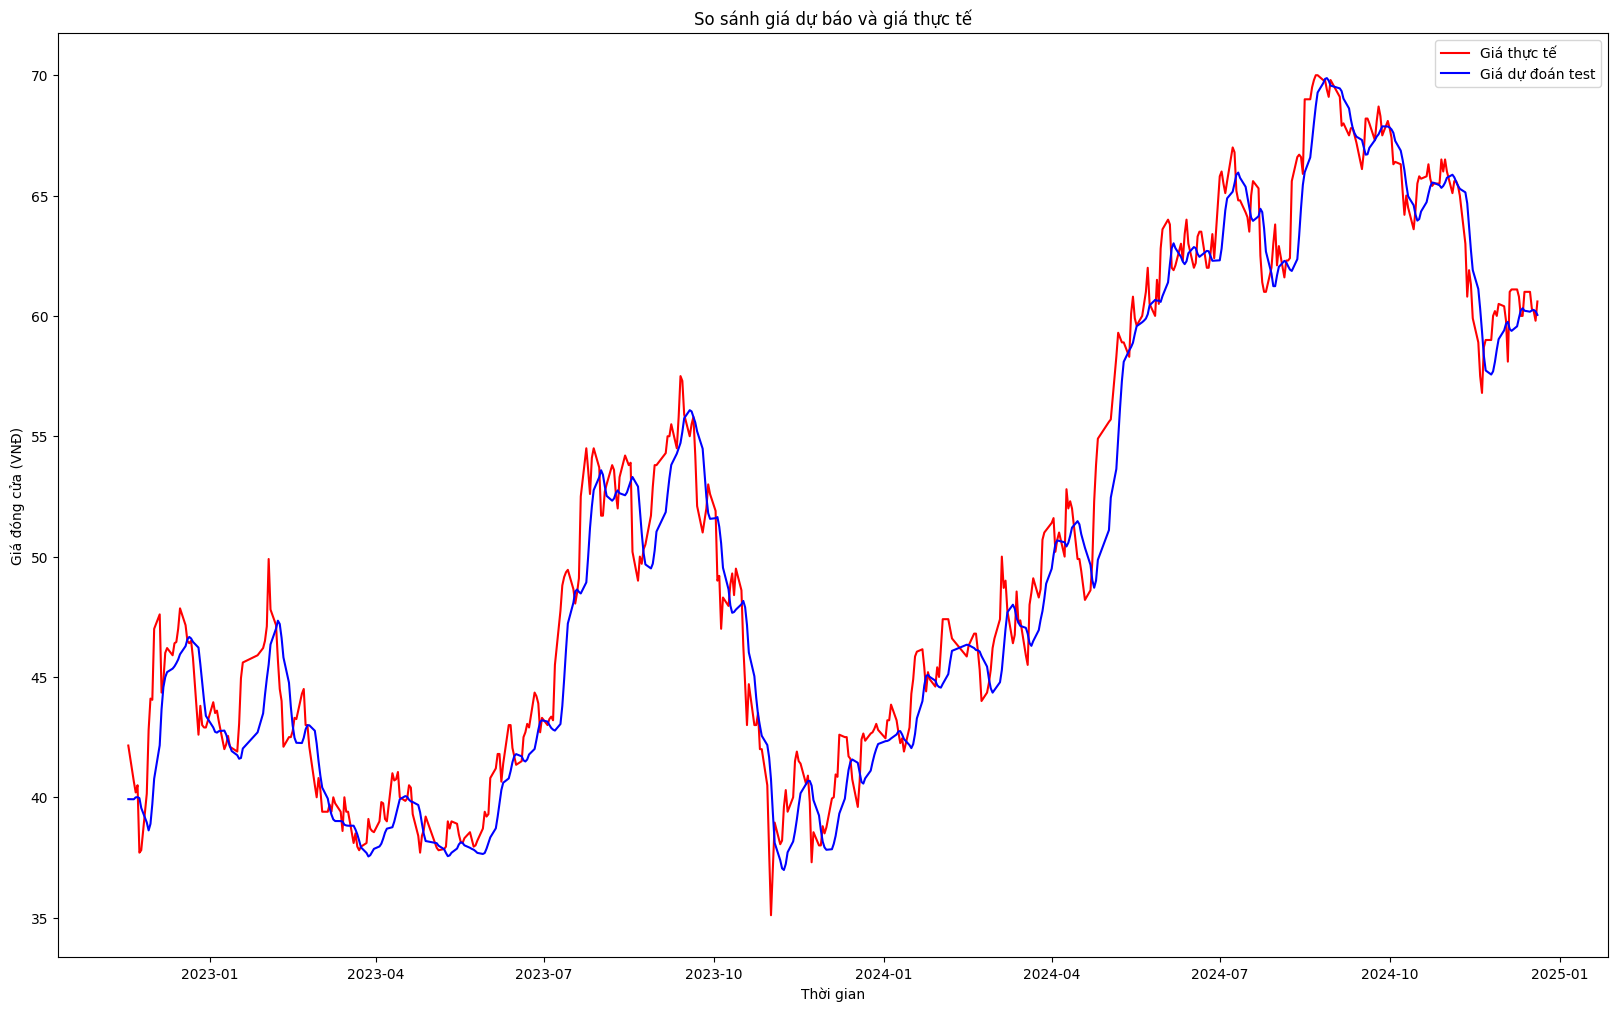

In [40]:
# Chọn dữ liệu cho test_data11
num_test_predictions = len(y_test_predict)
test_data1 = df.iloc[-num_test_predictions:].copy()
plt.figure(figsize=(20, 12))
if 'Ngay' in test_data1.columns:
    plt.plot(test_data1['Ngay'], test_data1['GiaDongCua'], label='Giá thực tế', color='red')
else:
    raise KeyError("Cột 'Ngày' không tồn tại trong test_data1.")

test_data1 = test_data1.copy()
test_data1['Dự đoán'] = y_test_predict.flatten()
plt.plot(test_data1['Ngay'], test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.title('So sánh giá dự báo và giá thực tế')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.legend()
plt.show()


In [18]:
print('--- Kết quả trên tập train ---')
# R2 score
print('Độ phù hợp tập train (R2):', r2_score(y_train, y_train_predict))

# MAE
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):', mean_absolute_error(y_train, y_train_predict))

# MAPE
print('Phần trăm sai số tuyệt đối trung bình trên tập train:', mean_absolute_percentage_error(y_train, y_train_predict) * 100)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predict))
print('RMSE trên tập train (VNĐ):', rmse_train)

# Accuracy (dựa trên RMSE và biên độ giá trị thực tế)
range_y_train = np.max(y_train) - np.min(y_train)
accuracy_train = 1 - (rmse_train / range_y_train)
print('Độ chính xác trên tập train (%):', accuracy_train * 100)

# F1 Score (Chuyển thành bài toán phân loại)
error_threshold = 10  # Ngưỡng sai số
y_train_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_train, y_train_predict)]
y_train_pred_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_train, y_train_predict)]
f1_train = f1_score(y_train_class, y_train_pred_class)
print('F1 Score trên tập train:', f1_train)
print("----------------------------------------------------")

--- Kết quả trên tập train ---
Độ phù hợp tập train (R2): 0.9685780805188658
Sai số tuyệt đối trung bình trên tập train (VNĐ): 2.628497358252888
Phần trăm sai số tuyệt đối trung bình trên tập train: 2.523512125553783
RMSE trên tập train (VNĐ): 5.242126088754189
Độ chính xác trên tập train (%): 96.39840186275906
F1 Score trên tập train: 1.0
----------------------------------------------------


In [19]:
y_test = data[-len(y_test_predict):]

In [20]:
print('--- Kết quả trên tập test ---')
# R2 score
print('Độ phù hợp tập test (R2):', r2_score(y_test, y_test_predict))

# MAE
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mean_absolute_error(y_test, y_test_predict))

# MAPE
print('Phần trăm sai số tuyệt đối trung bình trên tập test:', mean_absolute_percentage_error(y_test, y_test_predict) * 100)

# RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
print('RMSE trên tập test (VNĐ):', rmse_test)

# Accuracy (dựa trên RMSE và biên độ giá trị thực tế)
range_y_test = np.max(y_test) - np.min(y_test)
accuracy_test = 1 - (rmse_test / range_y_test)
print('Độ chính xác trên tập test (%):', accuracy_test * 100)

# F1 Score (Chuyển thành bài toán phân loại)
y_test_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_test, y_test_predict)]
y_test_pred_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_test, y_test_predict)]
f1_test = f1_score(y_test_class, y_test_pred_class)
print('F1 Score trên tập test:', f1_test)
print("----------------------------------------------------")

--- Kết quả trên tập test ---
Độ phù hợp tập test (R2): 0.9654658672640679
Sai số tuyệt đối trung bình trên tập test (VNĐ): 1.4199601080403954
Phần trăm sai số tuyệt đối trung bình trên tập test: 2.9019533205921655
RMSE trên tập test (VNĐ): 1.8430444695071826
Độ chính xác trên tập test (%): 94.71907028794504
F1 Score trên tập test: 1.0
----------------------------------------------------


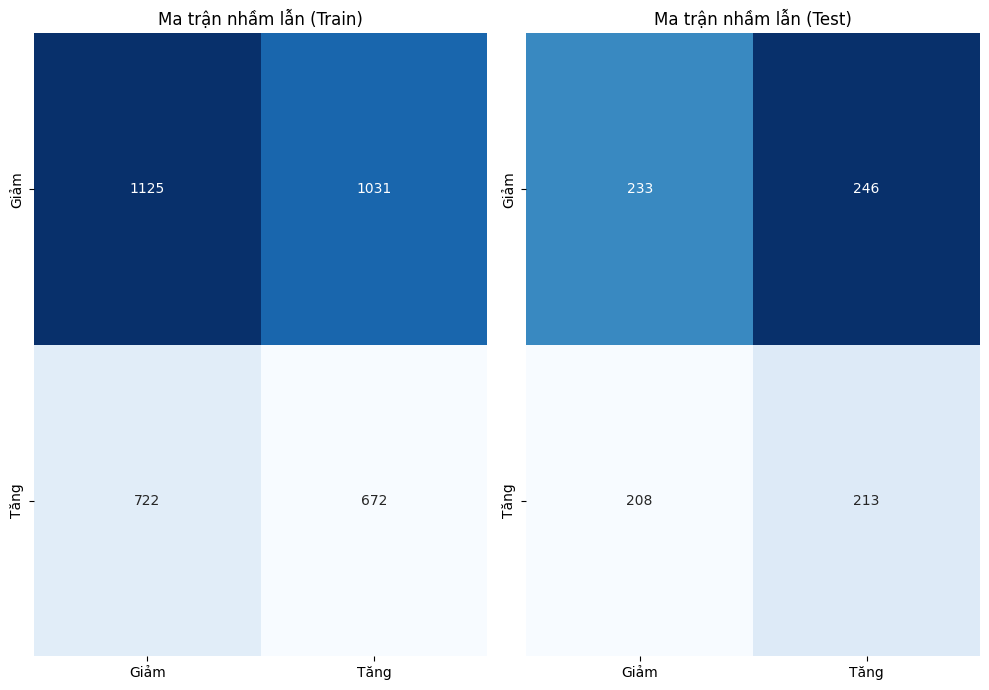

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def create_labels(data):
    return [1 if data[i] > data[i-1] else 0 for i in range(1, len(data))]

# Chuyển đổi giá trị thực tế và dự đoán thành nhãn phân loại
y_train_labels = create_labels(y_train)
y_train_predict_labels = create_labels(y_train_predict.flatten())

y_test_labels = create_labels(y_test)
y_test_predict_labels = create_labels(y_test_predict.flatten())

# Tạo ma trận nhầm lẫn cho tập train
cm_train = confusion_matrix(y_train_labels, y_train_predict_labels)
cm_test = confusion_matrix(y_test_labels, y_test_predict_labels)

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(10, 7))

# Ma trận nhầm lẫn cho tập train
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Giảm", "Tăng"], yticklabels=["Giảm", "Tăng"])
plt.title("Ma trận nhầm lẫn (Train)")

# Ma trận nhầm lẫn cho tập test
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Giảm", "Tăng"], yticklabels=["Giảm", "Tăng"])
plt.title("Ma trận nhầm lẫn (Test)")

plt.tight_layout()
plt.show()